In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
%matplotlib inline
import pickle
import pandas as pd
from tasks import wsd
from pathlib import Path
from tasks import wsd
from utils import nlp_tools
from tqdm.auto import tqdm
import numpy as np
import json
from flair.embeddings import TransformerWordEmbeddings
from utils.dataset_download import harvest_data_from_extended_senses
from utils.classificaton_utils import binarize, vectorize_target_expressions,cosine_similiarity

# Preparation

In [4]:
# import API credentials
with open('oed_experiments/oed_credentials.json') as f:
    auth = json.load(f)

In [10]:
# only run this once after downloading
# otherwise you remove the vectorized keywords
tqdm.pandas()
lemma,pos = 'machine', "NN"
#quotations = harvest_data_from_extended_senses(auth,f"{lemma}_{pos}")

# Vectorize data

In [48]:

quotations_path = "./data/sfrel_quotations_machine_NN.pickle"
embedding_methods = {'bert_base': {"path":'bert-base-uncased',
                                   'layers':'-1,-2,-3,-4',
                                   'pooling_operation':'mean'},
                     'blert': {"path":'/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002',
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1850':{"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001", 
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1900': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'}
                                    }
quotations = vectorize_target_expressions(quotations_path,embedding_methods)

Dataframe alread contains vectors from bert_base settings
{'path': 'bert-base-uncased', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from blert settings
{'path': '/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1850 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}


[WARNING] Could not properly match shake up  with  shake up			  Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] Could not properly match lay  with  layman  Return None.



In [56]:
# inspect vectorized notebook
df = pd.read_pickle("./data/sfrel_quotations_machine_NN.pickle")
df.head(3)

,sense_id,lemma_definition,definition,word_id,lemma,quotation_id,source,text,year,full_text,keyword,keyword_offset,"vector_bert_base_-1,-2,-3,-4_mean","vector_blert_-1,-2,-3,-4_mean","vector_bert_1850_-1,-2,-3,-4_mean","vector_bert_1900_-1,-2,-3,-4_mean"
0,carr_nn03-9982032,(See quot.),(See quot.),carr_nn03,carr,carr_nn03-9982036,"{'title': 'Nat. Hist. Staffs.', 'author': 'R. ...","{'keyword': 'Car', 'full_text': 'Whether they ...",1686.0,Whether they can find any coal water i.e. an a...,Car,65.0,"[0.057217587, 0.1470324, 0.43648225, -0.493824...","[-0.08749541, 0.1971384, 0.21954466, 0.226875,...","[0.12274607, 0.4780628, 0.20990661, 0.25732976...","[0.31108952, 0.048602477, 0.3429173, -0.156553..."
1,carr_nn03-9982032,(See quot.),(See quot.),carr_nn03,carr,carr_nn03-9982044,"{'title': 'O.C. & F. Words', 'author': 'R. Hol...","{'keyword': 'carr', 'full_text': 'The brown se...",1880.0,The brown sediment (humate of iron) deposited ...,carr,83.0,"[-0.08569695, 0.2822367, 0.53436506, -0.543560...","[-0.7660401, 0.41970345, 0.15370755, -0.262228...","[-0.60488343, 0.55647683, 0.19850555, -0.28652...","[-0.7844395, -0.020409506, 0.6728713, -0.45623..."
2,vehiculum_nn01-15938293,"A substance, esp. a liquid, which acts as a me...","A substance, esp. a liquid, which acts as a me...",vehiculum_nn01,vehiculum,vehiculum_nn01-1004413341,{'title': 'Diuers Chimicall Concl. Distillatio...,"{'keyword': 'vehiculum', 'full_text': 'Vse the...",1594.0,Vse the first water againe for the vehiculum i...,vehiculum,35.0,"[-0.6408355, -0.33204675, 0.23320119, -0.22713...","[-0.43212408, -0.01557897, 0.63128877, 0.25003...","[-0.68839765, 0.00055527687, 0.30988568, -0.06...","[-0.563795, -0.04185177, 0.32834733, -0.310258..."


# Disambiguation

In [58]:
senses = {'machine_nn01-38475923'}
relations = ['seed','synonym'] # ,'descendant','sibling'
eval_mode = "lemma_etal" # lemma or lemma_etal
    

In [59]:
df_train, df_val, df_test = binarize(lemma,
                        pos,
                        senses, 
                        relations,
                        strict_filter=True,
                        start=1700,
                        end=1920,
                        eval_mode=eval_mode)

Index(['sense_id', 'lemma_definition', 'definition', 'word_id', 'lemma',
       'quotation_id', 'source', 'text', 'year', 'full_text', 'keyword',
       'keyword_offset', 'vector_bert_base_-1,-2,-3,-4_mean',
       'vector_blert_-1,-2,-3,-4_mean', 'vector_bert_1850_-1,-2,-3,-4_mean',
       'vector_bert_1900_-1,-2,-3,-4_mean'],
      dtype='object')
# senses before filtering by date = 517
# senses after filtering by date = 368


# of seed senses 23 
# of synonyms 324 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 8 
# of branches selected 0


In [12]:
df_test.head()

,sense_id,lemma_definition,definition,word_id,lemma,quotation_id,source,text,year,full_text,keyword,keyword_offset,"vector_bert_base_-1,-2,-3,-4_mean",label,id,daterange,provenance,provenance_type,relation_to_core_senses,relation_to_seed_senses
108,machine_nn01-38475494,"A complex device, consisting of a number of in...",Used contextually for the particular kind of m...,machine_nn01,machine,machine_nn01-38475576,"{'title': None, 'author': 'W. D. Howells', 'ge...","{'keyword': 'machine', 'full_text': 'The machi...",1891.0,The machine with which this letter is written ...,machine,4.0,"[-0.23773926, 0.76330495, -0.18839866, -0.1579...",0,machine_nn01-38475494,"{'end': None, 'start': 1782, 'obsolete': False...","[[machine_nn01-38475494, seed, machine_nn01]]",seed,{machine_nn01-38475494},{machine_nn01-38475494}
316,mover_nn01-35821153,A person who sets or keeps something in motion...,"U.S. A migrant, a settler; spec. (a) a settler...",mover_nn01,mover,mover_nn01-35821179,"{'title': '2nd Visit U.S.', 'author': 'C. Lyel...","{'keyword': 'movers', 'full_text': 'On board w...",1849.0,On board were many ‘movers’ going to Texas wit...,movers,20.0,"[0.108669445, -0.036040783, 0.042272598, 0.319...",0,NaN,NaN,NaN,NaN,NaN,NaN
247,power_nn01-28687898,Ability to act or affect something strongly; p...,"Mechanics. In full mechanical power, †mathemat...",power_nn01,power,power_nn01-28687943,"{'title': 'Elements Physics', 'author': 'N. Ar...","{'keyword': 'mechanical power', 'full_text': '...",1827.0,No mechanical power or machine generates force.,mechanical power,3.0,"[0.68850386, 0.3318206, 0.30432534, 0.16182785...",1,power_nn01-28687898,"{'end': None, 'start': 1671, 'obsolete': False...","[[power_nn01-28687898, synonym, machine_nn01-3...",synonym,{machine_nn01-38475923},{machine_nn01-38475923}
97,machine_nn01-38474820,"A complex device, consisting of a number of in...",= bathing-machine n. at bathing n. compounds ...,machine_nn01,machine,machine_nn01-38474829,"{'title': 'Ipswich Jrnl.', 'author': None, 'ge...","{'keyword': 'Machine', 'full_text': 'At Aldebu...",1763.0,At Aldeburgh in Suffolk..for the Conveniency o...,Machine,111.0,"[0.16162382, 0.118292086, 0.044132993, 0.17878...",0,machine_nn01-38474820,"{'end': 1870, 'start': 1763, 'obsolete': True,...","[[machine_nn01-38474820, seed, machine_nn01]]",seed,{machine_nn01-38474820},{machine_nn01-38474820}
57,machine_nn01-38475994,"A complex device, consisting of a number of in...",figurative in general use.,machine_nn01,machine,machine_nn01-38476026,"{'title': 'Dispatches', 'author': 'Duke of Wel...","{'keyword': 'machine', 'full_text': 'More expe...",1801.0,More experience than we have yet had of the op...,machine,95.0,"[0.83684593, 0.5584122, -0.16416408, 0.2444155...",0,machine_nn01-38475994,"{'end': None, 'start': 1676, 'obsolete': False...","[[machine_nn01-38475994, seed, machine_nn01]]",seed,{machine_nn01-38475994},{machine_nn01-38475994}


In [60]:
vector_cols = [c for c in df_train.columns if c.startswith('vector_')]
vector_cols

['vector_bert_base_-1,-2,-3,-4_mean',
 'vector_blert_-1,-2,-3,-4_mean',
 'vector_bert_1850_-1,-2,-3,-4_mean',
 'vector_bert_1900_-1,-2,-3,-4_mean']

# NN Polarity

In [62]:

vector_type = vector_cols[0]
polar_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
polar_vectors
df_test[f"bert_nn_polar_{vector_type}"] = df_test[vector_type].progress_apply(wsd.bert_nn_polar_vector, polar_vectors = polar_vectors)
wsd.eval(f"bert_nn_polar_{vector_type}",df_test)
#polar_vectors



{'1': [0.353, 0.857, 0.5], '0': [0.98, 0.814, 0.889]}

# SemAxis

In [39]:
vector_type = vector_cols[0]
polar_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
sem_axis = polar_vectors[1] - polar_vectors[0] 
sims = df_val[vector_type].progress_apply(wsd.bert_contrast_vector, sem_axis=sem_axis, return_label=False)

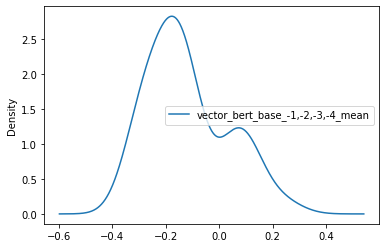

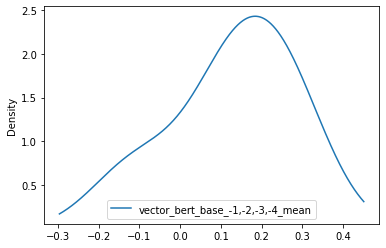

In [40]:
dfL = pd.DataFrame([sims,df_val.label]).T
dfL[dfL.label=="0"].plot(kind='density')
dfL[dfL.label=="1"].plot(kind='density')

In [63]:
df_test[f"bert_contrast_{vector_type}"] = df_test[vector_type].progress_apply(wsd.bert_contrast_vector, sem_axis=sem_axis, return_label=True, threshold=.0)
wsd.eval(f"bert_contrast_{vector_type}",df_test)

{'1': [0.353, 0.857, 0.5], '0': [0.98, 0.814, 0.889]}

# Time sensitive

In [111]:
df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_nn_ts_polar_vector, df_train=df_train, axis=1)
wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

{'1': [0.333, 0.429, 0.375], '0': [0.93, 0.898, 0.914]}